In [ ]:
import streamlit as st
import pandas as pd
import base64,random
import time,datetime
from pyresparser import ResumeParser
from pdfminer3.layout import LAParams, LTTextBox
from pdfminer3.pdfpage import PDFPage
from pdfminer3.pdfinterp import PDFResourceManager
from pdfminer3.pdfinterp import PDFPageInterpreter
from pdfminer3.converter import TextConverter
import io,random
from streamlit_tags import st_tags
from PIL import Image
import pymysql
from Courses import ds_course,web_course,android_course,ios_course,uiux_course,resume_videos,interview_videos
import pafy
import plotly.express as px

def fetch_yt_video(link):
    video = pafy.new(link)
    return video.title

def get_table_download_link(df,filename,text):
    """Generates a link allowing the data in a given panda dataframe to be downloaded
    in:  dataframe
    out: href string
    """
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode()).decode()  # some strings <-> bytes conversions necessary here
    # href = f'<a href="data:file/csv;base64,{b64}">Download Report</a>'
    href = f'<a href="data:file/csv;base64,{b64}" download="{filename}">{text}</a>'
    return href

def pdf_reader(file):
    resource_manager = PDFResourceManager()
    fake_file_handle = io.StringIO()
    converter = TextConverter(resource_manager, fake_file_handle, laparams=LAParams())
    page_interpreter = PDFPageInterpreter(resource_manager, converter)
    with open(file, 'rb') as fh:
        for page in PDFPage.get_pages(fh,
                                      caching=True,
                                      check_extractable=True):
            page_interpreter.process_page(page)
            print(page)
        text = fake_file_handle.getvalue()

    # close open handles
    converter.close()
    fake_file_handle.close()
    return text

def show_pdf(file_path):
    with open(file_path, "rb") as f:
        base64_pdf = base64.b64encode(f.read()).decode('utf-8')
    # pdf_display = f'<embed src="data:application/pdf;base64,{base64_pdf}" width="700" height="1000" type="application/pdf">'
    pdf_display = F'<iframe src="data:application/pdf;base64,{base64_pdf}" width="700" height="1000" type="application/pdf"></iframe>'
    st.markdown(pdf_display, unsafe_allow_html=True)

def course_recommender(course_list):
    st.subheader("**Courses & Certificates🎓 Recommendations**")
    c = 0
    rec_course = []
    no_of_reco = st.slider('Choose Number of Course Recommendations:', 1, 10, 4)
    random.shuffle(course_list)
    for c_name, c_link in course_list:
        c += 1
        st.markdown(f"({c}) [{c_name}]({c_link})")
        rec_course.append(c_name)
        if c == no_of_reco:
            break
    return rec_course

connection = pymysql.connect(host='localhost',user='root',password='',db='sra')
cursor = connection.cursor()

def insert_data(name,email,res_score,timestamp,no_of_pages,reco_field,cand_level,skills,recommended_skills,courses):
    DB_table_name = 'user_data'
    insert_sql = "insert into " + DB_table_name + """
    values (0,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s)"""
    rec_values = (name, email, str(res_score), timestamp,str(no_of_pages), reco_field, cand_level, skills,recommended_skills,courses)
    cursor.execute(insert_sql, rec_values)
    connection.commit()

st.set_page_config(
   page_title="Smart Resume Analyzer",
   page_icon='./Logo/SRA_Logo.ico',
)
def run():
    st.title("Smart Resume Analyser")
    st.sidebar.markdown("# Choose User")
    activities = ["Normal User", "Admin"]
    choice = st.sidebar.selectbox("Choose among the given options:", activities)
    # link = '[©Developed by Spidy20](http://github.com/spidy20)'
    # st.sidebar.markdown(link, unsafe_allow_html=True)
    img = Image.open('./Logo/SRA_Logo.jpg')
    img = img.resize((250,250))
    st.image(img)

    # Create the DB
    db_sql = """CREATE DATABASE IF NOT EXISTS SRA;"""
    cursor.execute(db_sql)

    # Create table
    DB_table_name = 'user_data'
    table_sql = "CREATE TABLE IF NOT EXISTS " + DB_table_name + """
                    (ID INT NOT NULL AUTO_INCREMENT,
                     Name varchar(100) NOT NULL,
                     Email_ID VARCHAR(50) NOT NULL,
                     resume_score VARCHAR(8) NOT NULL,
                     Timestamp VARCHAR(50) NOT NULL,
                     Page_no VARCHAR(5) NOT NULL,
                     Predicted_Field VARCHAR(25) NOT NULL,
                     User_level VARCHAR(30) NOT NULL,
                     Actual_skills VARCHAR(300) NOT NULL,
                     Recommended_skills VARCHAR(300) NOT NULL,
                     Recommended_courses VARCHAR(600) NOT NULL,
                     PRIMARY KEY (ID));
                    """
    cursor.execute(table_sql)
    if choice == 'Normal User':
        # st.markdown('''<h4 style='text-align: left; color: #d73b5c;'>* Upload your resume, and get smart recommendation based on it."</h4>''',
        #             unsafe_allow_html=True)
        pdf_file = st.file_uploader("Choose your Resume", type=["pdf"])
        if pdf_file is not None:
            # with st.spinner('Uploading your Resume....'):
            #     time.sleep(4)
            save_image_path = './Uploaded_Resumes/'+pdf_file.name
            with open(save_image_path, "wb") as f:
                f.write(pdf_file.getbuffer())
            show_pdf(save_image_path)
            resume_data = ResumeParser(save_image_path).get_extracted_data()
            if resume_data:
                ## Get the whole resume data
                resume_text = pdf_reader(save_image_path)

                st.header("**Resume Analysis**")
                st.success("Hello "+ resume_data['name'])
                st.subheader("**Your Basic info**")
                try:
                    st.text('Name: '+resume_data['name'])
                    st.text('Email: ' + resume_data['email'])
                    st.text('Contact: ' + resume_data['mobile_number'])
                    st.text('Resume pages: '+str(resume_data['no_of_pages']))
                except:
                    pass
                cand_level = ''
                if resume_data['no_of_pages'] == 1:
                    cand_level = "Fresher"
                    st.markdown( '''<h4 style='text-align: left; color: #d73b5c;'>You are looking Fresher.</h4>''',unsafe_allow_html=True)
                elif resume_data['no_of_pages'] == 2:
                    cand_level = "Intermediate"
                    st.markdown('''<h4 style='text-align: left; color: #1ed760;'>You are at intermediate level!</h4>''',unsafe_allow_html=True)
                elif resume_data['no_of_pages'] >=3:
                    cand_level = "Experienced"
                    st.markdown('''<h4 style='text-align: left; color: #fba171;'>You are at experience level!''',unsafe_allow_html=True)

                st.subheader("**Skills Recommendation💡**")
                ## Skill shows
                keywords = st_tags(label='### Skills that you have',
                text='See our skills recommendation',
                    value=resume_data['skills'],key = '1')

                ##  recommendation
                ds_keyword = ['tensorflow','keras','pytorch','machine learning','deep Learning','flask','streamlit']
                web_keyword = ['react', 'django', 'node jS', 'react js', 'php', 'laravel', 'magento', 'wordpress',
                               'javascript', 'angular js', 'c#', 'flask']
                android_keyword = ['android','android development','flutter','kotlin','xml','kivy']
                ios_keyword = ['ios','ios development','swift','cocoa','cocoa touch','xcode']
                uiux_keyword = ['ux','adobe xd','figma','zeplin','balsamiq','ui','prototyping','wireframes','storyframes','adobe photoshop','photoshop','editing','adobe illustrator','illustrator','adobe after effects','after effects','adobe premier pro','premier pro','adobe indesign','indesign','wireframe','solid','grasp','user research','user experience']

                recommended_skills = []
                reco_field = ''
                rec_course = ''
                ## Courses recommendation
                for i in resume_data['skills']:
                    ## Data science recommendation
                    if i.lower() in ds_keyword:
                        print(i.lower())
                        reco_field = 'Data Science'
                        st.success("** Our analysis says you are looking for Data Science Jobs.**")
                        recommended_skills = ['Data Visualization','Predictive Analysis','Statistical Modeling','Data Mining','Clustering & Classification','Data Analytics','Quantitative Analysis','Web Scraping','ML Algorithms','Keras','Pytorch','Probability','Scikit-learn','Tensorflow',"Flask",'Streamlit']
                        recommended_keywords = st_tags(label='### Recommended skills for you.',
                        text='Recommended skills generated from System',value=recommended_skills,key = '2')
                        st.markdown('''<h4 style='text-align: left; color: #1ed760;'>Adding this skills to resume will boost🚀 the chances of getting a Job💼</h4>''',unsafe_allow_html=True)
                        rec_course = course_recommender(ds_course)
                        break

                    ## Web development recommendation
                    elif i.lower() in web_keyword:
                        print(i.lower())
                        reco_field = 'Web Development'
                        st.success("** Our analysis says you are looking for Web Development Jobs **")
                        recommended_skills = ['React','Django','Node JS','React JS','php','laravel','Magento','wordpress','Javascript','Angular JS','c#','Flask','SDK']
                        recommended_keywords = st_tags(label='### Recommended skills for you.',
                        text='Recommended skills generated from System',value=recommended_skills,key = '3')
                        st.markdown('''<h4 style='text-align: left; color: #1ed760;'>Adding this skills to resume will boost🚀 the chances of getting a Job💼</h4>''',unsafe_allow_html=True)
                        rec_course = course_recommender(web_course)
                        break

                    ## Android App Development
                    elif i.lower() in android_keyword:
                        print(i.lower())
                        reco_field = 'Android Development'
                        st.success("** Our analysis says you are looking for Android App Development Jobs **")
                        recommended_skills = ['Android','Android development','Flutter','Kotlin','XML','Java','Kivy','GIT','SDK','SQLite']
                        recommended_keywords = st_tags(label='### Recommended skills for you.',
                        text='Recommended skills generated from System',value=recommended_skills,key = '4')
                        st.markdown('''<h4 style='text-align: left; color: #1ed760;'>Adding this skills to resume will boost🚀 the chances of getting a Job💼</h4>''',unsafe_allow_html=True)
                        rec_course = course_recommender(android_course)
                        break

                    ## IOS App Development
                    elif i.lower() in ios_keyword:
                        print(i.lower())
                        reco_field = 'IOS Development'
                        st.success("** Our analysis says you are looking for IOS App Development Jobs **")
                        recommended_skills = ['IOS','IOS Development','Swift','Cocoa','Cocoa Touch','Xcode','Objective-C','SQLite','Plist','StoreKit',"UI-Kit",'AV Foundation','Auto-Layout']
                        recommended_keywords = st_tags(label='### Recommended skills for you.',
                        text='Recommended skills generated from System',value=recommended_skills,key = '5')
                        st.markdown('''<h4 style='text-align: left; color: #1ed760;'>Adding this skills to resume will boost🚀 the chances of getting a Job💼</h4>''',unsafe_allow_html=True)
                        rec_course = course_recommender(ios_course)
                        break

                    ## Ui-UX Recommendation
                    elif i.lower() in uiux_keyword:
                        print(i.lower())
                        reco_field = 'UI-UX Development'
                        st.success("** Our analysis says you are looking for UI-UX Development Jobs **")
                        recommended_skills = ['UI','User Experience','Adobe XD','Figma','Zeplin','Balsamiq','Prototyping','Wireframes','Storyframes','Adobe Photoshop','Editing','Illustrator','After Effects','Premier Pro','Indesign','Wireframe','Solid','Grasp','User Research']
                        recommended_keywords = st_tags(label='### Recommended skills for you.',
                        text='Recommended skills generated from System',value=recommended_skills,key = '6')
                        st.markdown('''<h4 style='text-align: left; color: #1ed760;'>Adding this skills to resume will boost🚀 the chances of getting a Job💼</h4>''',unsafe_allow_html=True)
                        rec_course = course_recommender(uiux_course)
                        break

                #
                ## Insert into table
                ts = time.time()
                cur_date = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d')
                cur_time = datetime.datetime.fromtimestamp(ts).strftime('%H:%M:%S')
                timestamp = str(cur_date+'_'+cur_time)

                ### Resume writing recommendation
                st.subheader("**Resume Tips & Ideas💡**")
                resume_score = 0
                if 'Objective' in resume_text:
                    resume_score = resume_score+20
                    st.markdown('''<h4 style='text-align: left; color: #1ed760;'>[+] Awesome! You have added Objective</h4>''',unsafe_allow_html=True)
                else:
                    st.markdown('''<h4 style='text-align: left; color: #fabc10;'>[-] According to our recommendation please add your career objective, it will give your career intension to the Recruiters.</h4>''',unsafe_allow_html=True)

                if 'Declaration'  in resume_text:
                    resume_score = resume_score + 20
                    st.markdown('''<h4 style='text-align: left; color: #1ed760;'>[+] Awesome! You have added Delcaration✍/h4>''',unsafe_allow_html=True)
                else:
                    st.markdown('''<h4 style='text-align: left; color: #fabc10;'>[-] According to our recommendation please add Declaration✍. It will give the assurance that everything written on your resume is true and fully acknowledged by you</h4>''',unsafe_allow_html=True)

                if 'Hobbies' or 'Interests'in resume_text:
                    resume_score = resume_score + 20
                    st.markdown('''<h4 style='text-align: left; color: #1ed760;'>[+] Awesome! You have added your Hobbies⚽</h4>''',unsafe_allow_html=True)
                else:
                    st.markdown('''<h4 style='text-align: left; color: #fabc10;'>[-] According to our recommendation please add Hobbies⚽. It will show your persnality to the Recruiters and give the assurance that you are fit for this role or not.</h4>''',unsafe_allow_html=True)

                if 'Achievements' in resume_text:
                    resume_score = resume_score + 20
                    st.markdown('''<h4 style='text-align: left; color: #1ed760;'>[+] Awesome! You have added your Achievements🏅 </h4>''',unsafe_allow_html=True)
                else:
                    st.markdown('''<h4 style='text-align: left; color: #fabc10;'>[-] According to our recommendation please add Achievements🏅. It will show that you are capable for the required position.</h4>''',unsafe_allow_html=True)

                if 'Projects' in resume_text:
                    resume_score = resume_score + 20
                    st.markdown('''<h4 style='text-align: left; color: #1ed760;'>[+] Awesome! You have added your Projects👨‍💻 </h4>''',unsafe_allow_html=True)
                else:
                    st.markdown('''<h4 style='text-align: left; color: #fabc10;'>[-] According to our recommendation please add Projects👨‍💻. It will show that you have done work related the required position or not.</h4>''',unsafe_allow_html=True)

                st.subheader("**Resume Score📝**")
                st.markdown(
                    """
                    <style>
                        .stProgress > div > div > div > div {
                            background-color: #d73b5c;
                        }
                    </style>""",
                    unsafe_allow_html=True,
                )
                my_bar = st.progress(0)
                score = 0
                for percent_complete in range(resume_score):
                    score +=1
                    time.sleep(0.1)
                    my_bar.progress(percent_complete + 1)
                st.success('** Your Resume Writing Score: ' + str(score)+'**')
                st.warning("** Note: This score is calculated based on the content that you have added in your Resume. **")
                st.balloons()

                insert_data(resume_data['name'], resume_data['email'], str(resume_score), timestamp,
                              str(resume_data['no_of_pages']), reco_field, cand_level, str(resume_data['skills']),
                              str(recommended_skills), str(rec_course))


                ## Resume writing video
                st.header("**Bonus Video for Resume Writing Tips💡**")
                resume_vid = random.choice(resume_videos)
                res_vid_title = fetch_yt_video(resume_vid)
                st.subheader("✅ **"+res_vid_title+"**")
                st.video(resume_vid)

                ## Interview Preparation Video
                st.header("**Bonus Video for Interview👨‍💼 Tips💡**")
                interview_vid = random.choice(interview_videos)
                int_vid_title = fetch_yt_video(interview_vid)
                st.subheader("✅ **" + int_vid_title + "**")
                st.video(interview_vid)

                connection.commit()
            else:
                st.error('Something went wrong..')
    else:
        ## Admin Side
        st.success('Welcome to Admin Side')
        # st.sidebar.subheader('**ID / Password Required!**')

        ad_user = st.text_input("Username")
        ad_password = st.text_input("Password", type='password')
        if st.button('Login'):
            if ad_user == 'machine_learning_hub' and ad_password == 'mlhub123':
                st.success("Welcome Kushal")
                # Display Data
                cursor.execute('''SELECT*FROM user_data''')
                data = cursor.fetchall()
                st.header("**User's👨‍💻 Data**")
                df = pd.DataFrame(data, columns=['ID', 'Name', 'Email', 'Resume Score', 'Timestamp', 'Total Page',
                                                 'Predicted Field', 'User Level', 'Actual Skills', 'Recommended Skills',
                                                 'Recommended Course'])
                st.dataframe(df)
                st.markdown(get_table_download_link(df,'User_Data.csv','Download Report'), unsafe_allow_html=True)
                ## Admin Side Data
                query = 'select * from user_data;'
                plot_data = pd.read_sql(query, connection)

                ## Pie chart for predicted field recommendations
                labels = plot_data.Predicted_Field.unique()
                print(labels)
                values = plot_data.Predicted_Field.value_counts()
                print(values)
                st.subheader("📈 **Pie-Chart for Predicted Field Recommendations**")
                fig = px.pie(df, values=values, names=labels, title='Predicted Field according to the Skills')
                st.plotly_chart(fig)

                ### Pie chart for User's👨‍💻 Experienced Level
                labels = plot_data.User_level.unique()
                values = plot_data.User_level.value_counts()
                st.subheader("📈 ** Pie-Chart for User's👨‍💻 Experienced Level**")
                fig = px.pie(df, values=values, names=labels, title="Pie-Chart📈 for User's👨‍💻 Experienced Level")
                st.plotly_chart(fig)


            else:
                st.error("Wrong ID & Password Provided")
run()

ModuleNotFoundError: ignored

In [ ]:
import spacy

In [ ]:
print(spacy._version_)

NameError: ignored

In [ ]:
import pickle

In [ ]:
import random

In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
# data = pd.read_pkl('/content/drive/MyDrive/Ibtasam Ahmad DATA/train_data.pkl')

Mounted at /content/drive/


In [ ]:
train_data = pickle.load(open('/content/drive/MyDrive/Ibtasam Ahmad DATA/train_data.pkl','rb'))

In [ ]:
train_data

[('Govardhana K Senior Software Engineer  Bengaluru, Karnataka, Karnataka - Email me on Indeed: indeed.com/r/Govardhana-K/ b2de315d95905b68  Total IT experience 5 Years 6 Months Cloud Lending Solutions INC 4 Month • Salesforce Developer Oracle 5 Years 2 Month • Core Java Developer Languages Core Java, Go Lang Oracle PL-SQL programming, Sales Force Developer with APEX.  Designations & Promotions  Willing to relocate: Anywhere  WORK EXPERIENCE  Senior Software Engineer  Cloud Lending Solutions -  Bangalore, Karnataka -  January 2018 to Present  Present  Senior Consultant  Oracle -  Bangalore, Karnataka -  November 2016 to December 2017  Staff Consultant  Oracle -  Bangalore, Karnataka -  January 2014 to October 2016  Associate Consultant  Oracle -  Bangalore, Karnataka -  November 2012 to December 2013  EDUCATION  B.E in Computer Science Engineering  Adithya Institute of Technology -  Tamil Nadu  September 2008 to June 2012  https://www.indeed.com/r/Govardhana-K/b2de315d95905b68?isid=rex

In [ ]:
train_data[0]

('Govardhana K Senior Software Engineer  Bengaluru, Karnataka, Karnataka - Email me on Indeed: indeed.com/r/Govardhana-K/ b2de315d95905b68  Total IT experience 5 Years 6 Months Cloud Lending Solutions INC 4 Month • Salesforce Developer Oracle 5 Years 2 Month • Core Java Developer Languages Core Java, Go Lang Oracle PL-SQL programming, Sales Force Developer with APEX.  Designations & Promotions  Willing to relocate: Anywhere  WORK EXPERIENCE  Senior Software Engineer  Cloud Lending Solutions -  Bangalore, Karnataka -  January 2018 to Present  Present  Senior Consultant  Oracle -  Bangalore, Karnataka -  November 2016 to December 2017  Staff Consultant  Oracle -  Bangalore, Karnataka -  January 2014 to October 2016  Associate Consultant  Oracle -  Bangalore, Karnataka -  November 2012 to December 2013  EDUCATION  B.E in Computer Science Engineering  Adithya Institute of Technology -  Tamil Nadu  September 2008 to June 2012  https://www.indeed.com/r/Govardhana-K/b2de315d95905b68?isid=rex-

In [ ]:
nlp = spacy.blank('en')

# @Language.component("component")
# @Language.factory("component")
def train_model(train_data):
  if 'ner' not in nlp.pipe_names:
    ner = nlp.add_pipe('ner')
    nlp.add_pipe(ner, last = True)

  for _, annotation in train_data:
    for ent in annotation['entities']:
      ner.add_label(ent[2])

  other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
  with nlp.disable_pipes(*other_pipes):
    optimizer = nlp.begin_training()
    for itn in range(10):
      print("strating iteration "+ str(int))
      random.shuffle(train_data)
      losses = {}
      index = 0
      for text, annotations in train_data:
        try:
          nlp.update(
              [text],
              [annotations],
              drop = 0.2,
              sgd = optimizer,
              losses = losses
          )
        except Exception as e:
          pass


      print(losses)


      

In [ ]:
train_model(train_data)

ValueError: ignored

In [ ]:
# ruler = nlp.add_pipe("entity_ruler")
# ruler.add_patterns(...)

In [ ]:
train_model(train_data)

ValueError: ignored

In [ ]:
optimizer = nlp.begin_training()
batch_size = 5
epochs = 20

In [ ]:
train_model(nlp, train_data, optimizer, batch_size, epochs)


TypeError: ignored

In [ ]:
!pip install pyresparser

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 8.2 MB/s 
     |████████████████████████████████| 5.6 MB 48.4 MB/s 
     |████████████████████████████████| 2.3 MB 46.4 MB/s 
     |████████████████████████████████| 139 kB 69.1 MB/s 
     |████████████████████████████████| 4.1 MB 48.6 MB/s 
     |████████████████████████████████| 127 kB 58.0 MB/s 
  Created wheel for docx2txt: filename=docx2txt-0.8-py3-none-any.whl size=3980 sha256=409293a574ea8b6ab891226c482f25fce9579e8ca86c2786ff5416daa7198fb8
  Stored in directory: /root/.cache/pip/wheels/b7/20/b2/473e3aea9a0c0d3e7b2f7bd81d06d0794fec12752733d1f3a8
Successfully built docx2txt
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. Th

In [ ]:
!pip install docx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 54 kB 2.8 MB/s 
  Created wheel for docx: filename=docx-0.2.4-py3-none-any.whl size=53924 sha256=d39e47dfbd17d592c1b7e06fed0bea958b43d0531ca5b3926cc88372b1f76f3e
  Stored in directory: /root/.cache/pip/wheels/dc/ac/45/846e21706415c92fc6e0964e343be1eb31cfc63e149dee5fbe
Successfully built docx


In [ ]:
!pip install python-docx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.6 MB 9.0 MB/s 
  Created wheel for python-docx: filename=python_docx-0.8.11-py3-none-any.whl size=184507 sha256=fd9e3195953eb3a36169afe78371d013dc692c2f56cfd9f472edc93e8d958974
  Stored in directory: /root/.cache/pip/wheels/f6/6f/b9/d798122a8b55b74ad30b5f52b01482169b445fbb84a11797a6
Successfully built python-docx


In [ ]:
import nltk

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from pyresparser import ResumeParser
import os
from docx import Document

In [ ]:
filed=input()

job


In [ ]:
try:
    doc = Document()
    with open(filed, 'r') as file:
        doc.add_paragraph(file.read())
    doc.save("text.docx")
    data = ResumeParser('text.docx').get_extracted_data()
    print(data['skills'])
except:
    data = ResumeParser(filed).get_extracted_data()
    print(data['skills'])

/usr/local/lib/python3.7/dist-packages/spacy/util.py:873: UserWarning: [W094] Model 'en_training' (0.0.0) specifies an under-constrained spaCy version requirement: >=2.1.4. This can lead to compatibility problems with older versions, or as new spaCy versions are released, because the model may say it's compatible when it's not. Consider changing the "spacy_version" in your meta.json to a version range, with a lower and upper pin. For example: >=3.4.1,<3.5.0
  warnings.warn(warn_msg)


OSError: ignored

In [ ]:
!pip install pdfminer.six


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.6 MB 4.9 MB/s 
     |████████████████████████████████| 4.1 MB 44.9 MB/s 


In [ ]:
from pdfminer.high_level import extract_text
 
 
def extract_text_from_pdf(pdf_path):
    return extract_text(pdf_path)
 
 
if __name__ == '__main__':
    print(extract_text_from_pdf('/content/drive/MyDrive/CV..pdf')) 

MOBILE NO:   +92 (332) 4650527 

EMAIL:            shibtasam@gmail.com 

LINKEDIN: 
72b69b206 

linkedin.com/in/ibtasam-ahmad- 

Professional Skills 

COPY-WRITING 

GRAPHIC DESIGNING 

WEBSITE DEVELOPMENT 

TEACHING 

MICROSOFT OFFICE 

TEAM MANAGEMENT 

Personal Skills 

TEAM PLAYER 

TIME MANAGEMENT 

CREATIVE SPIRIT 

DISCIPLINED 

MOTIVATED 

IBTASAM 
AHMAD 

Enthusiastic, ambitious, 
determined and goal 
oriented individual, eager to 
work in a 
professional environment to 
grow and embrace new 
learnings along the way !!! 

Experience 

ONLINE TUTORING 

GRAPHIC DESIGNING 

Educational Background 

COMMUNICATION SKILLS 

OCTOBER 2019 – PRESENT 
BS COMPUTATIONAL PHYSICS, 
PUNJAB UNIVERSITY LAHORE 
A+ GRADE (4th semester), 

APRIL 2017 – APRIL 2019 
INTERMEDIATE PRE- 
ENGINEERING, KIPS COLLEGE 
LHR 
A+ GRADE 

MARCH 2015 – MARCH 2017 
POST SECONDARY SCIENCE, 
THE MESSAGE SCHOOL LHR 
A+ GRADE 

Certifications 

AWS S3 BASICS (AMAZON WEB SERVICES) 
ANSYA STRUCTURAL ANALYSIS (ITSONIX

In [ ]:

!pip install nltk
!pip install numpy # (also required by nltk, for running the following code)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# !pip install d


# import docx2txt
import nltk
 
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
 
 
def extract_text_from_pdf(pdf_path):
    return extract_text(pdf_path)
    if txt:
        return txt.replace('\t', ' ')
    return None
 
 
def extract_names(txt):
    person_names = []
 
    for sent in nltk.sent_tokenize(txt):
        for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent))):
            if hasattr(chunk, 'label') and chunk.label() == 'PERSON':
                person_names.append(
                    ' '.join(chunk_leave[0] for chunk_leave in chunk.leaves())
                )
 
    return person_names
 
 
if __name__ == '__main__':
    text = extract_text_from_pdf('/content/drive/MyDrive/Resume..pdf')
    names = extract_names(text)
 
    if names:
        print(names[0])  # noqa: T001

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


Linkedin


In [25]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [ ]:
import pickle
import random
import pandas as pd

In [26]:
from pdfminer.high_level import extract_text
import nltk
 
 
def extract_text_from_pdf(pdf_path):
    return extract_text(pdf_path)
 
 
def extract_names(txt):
    person_names = []
 
    for sent in nltk.sent_tokenize(txt):
        for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent))):
            if hasattr(chunk, 'label') and chunk.label() == 'PERSON':
                person_names.append(
                    ' '.join(chunk_leave[0] for chunk_leave in chunk.leaves())
                )
 
    return person_names
 
 
if __name__ == '__main__':
    text = extract_text_from_pdf('/content/drive/MyDrive/Resume/CV..pdf')
    print(text)
    names = extract_names(text)
    if names:
        print(names[0])

MOBILE NO:   +92 (332) 4650527 

EMAIL:            shibtasam@gmail.com 

LINKEDIN: 
72b69b206 

linkedin.com/in/ibtasam-ahmad- 

Professional Skills 

COPY-WRITING 

GRAPHIC DESIGNING 

WEBSITE DEVELOPMENT 

TEACHING 

MICROSOFT OFFICE 

TEAM MANAGEMENT 

Personal Skills 

TEAM PLAYER 

TIME MANAGEMENT 

CREATIVE SPIRIT 

DISCIPLINED 

MOTIVATED 

IBTASAM 
AHMAD 

Enthusiastic, ambitious, 
determined and goal 
oriented individual, eager to 
work in a 
professional environment to 
grow and embrace new 
learnings along the way !!! 

Experience 

ONLINE TUTORING 

GRAPHIC DESIGNING 

Educational Background 

COMMUNICATION SKILLS 

OCTOBER 2019 – PRESENT 
BS COMPUTATIONAL PHYSICS, 
PUNJAB UNIVERSITY LAHORE 
A+ GRADE (4th semester), 

APRIL 2017 – APRIL 2019 
INTERMEDIATE PRE- 
ENGINEERING, KIPS COLLEGE 
LHR 
A+ GRADE 

MARCH 2015 – MARCH 2017 
POST SECONDARY SCIENCE, 
THE MESSAGE SCHOOL LHR 
A+ GRADE 

Certifications 

AWS S3 BASICS (AMAZON WEB SERVICES) 
ANSYA STRUCTURAL ANALYSIS (ITSONIX

In [27]:
import nltk
 
nltk.download('stopwords')
 
# you may read the database from a csv file or some other database
SKILLS_DB = [
    'machine learning',
    'data science',
    'leadership',
    'python',
    'word',
    'database expert',
    'data analysis',
    'communication skills',
    'database expert',
    'microsoft office',
    'administrative experience',
    'deep learning',
    'customer service'
]
 
 
def extract_text_from_pdf(pdf_path):
    return extract_text(pdf_path)
 
 
def extract_skills(input_text):
    stop_words = set(nltk.corpus.stopwords.words('english'))
    word_tokens = nltk.tokenize.word_tokenize(input_text)
 
    # remove the stop words
    filtered_tokens = [w for w in word_tokens if w not in stop_words]
 
    # remove the punctuation
    filtered_tokens = [w for w in word_tokens if w.isalpha()]
 
    # generate bigrams and trigrams (such as artificial intelligence)
    bigrams_trigrams = list(map(' '.join, nltk.everygrams(filtered_tokens, 2, 3)))
 
    # we create a set to keep the results in.
    found_skills = set()
 
    # we search for each token in our skills database
    for token in filtered_tokens:
        if token.lower() in SKILLS_DB:
            found_skills.add(token)
 
    # we search for each bigram and trigram in our skills database
    for ngram in bigrams_trigrams:
        if ngram.lower() in SKILLS_DB:
            found_skills.add(ngram)
 
    return found_skills
 
 
if __name__ == '__main__':
    text = extract_text_from_pdf('/content/drive/MyDrive/Resume..pdf')
    print(text)
    skills = extract_skills(text)
    a=input()
    for i in skills:
      if a==i:
        print('job is relevent to this person')
    print(skills)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


IBTASAM
AHMAD

C O N T A C T

Mobile
Email
Linkedin

+92 (332) 4650527 
shibtasam@gmail.com
linkedin.com/in/ibtasam-ahmad-
72b69b206

W O R K
E X P E R I E N C E

2021

2021

ONLINE TUTORING

GRAPHIC DESIGNING

E D U C A T I O N

2019-
Present

PUNJAB UNIVERSITY LAHORE
BS HONS Computational Physics

2017

KIPS COLLEGE LAHORE
Intermediate Pre-Engineering

C E R T I F I C A T E S

S K I L L S

Organic Marketing
Introduction to IOT
Critical Thinking
User Experience, User
Research
AWS S3 Basics
Creative Writing

ANSYS Structural
Analysis
Introduction to Cyber
Security
Data Science & Data
Analysis
Graphic Designing

Copy-Writing
Graphic Designing
Website Developement
Teaching
Microsoft Office
Team Management

Team Player
Time Management
Creative Spirit
Disciplined
Motivated
Communication Skills


ml
{'Data Science', 'Data Analysis', 'Microsoft Office', 'Communication Skills'}


In [ ]:
import nltk
 
nltk.download('stopwords')
 
# you may read the database from a csv file or some other database
SKILLS_DB = [
    'machine learning',
    'data science',
    'Data scientist',
    'python',
    'word',
    'excel',
    'English',
    'graphic designing',
    'communication skills',
]
 
 
def extract_text_from_pdf(pdf_path):
    return extract_text(pdf_path)
 
 
def extract_skills(input_text):
    stop_words = set(nltk.corpus.stopwords.words('english'))
    word_tokens = nltk.tokenize.word_tokenize(input_text)
    # remove the stop words
    filtered_tokens = [w for w in word_tokens if w not in stop_words]
    print(filtered_tokens)
 
    # remove the punctuation
    filtered_tokens = [w for w in word_tokens if w.isalpha()]
 
    # generate bigrams and trigrams (such as artificial intelligence)
    bigrams_trigrams = list(map(' '.join, nltk.everygrams(word_tokens, 2, 3)))
    print(bigrams_trigrams)
 
    # we create a set to keep the results in.
    found_skills = set()
    print(found_skills)
    # we search for each token in our skills database
    for token in bigrams_trigrams:
        if token.lower() in SKILLS_DB:
            found_skills.add(token)
 
    # we search for each bigram and trigram in our skills database
    for ngram in bigrams_trigrams:
        if ngram.lower() in SKILLS_DB:
            found_skills.add(ngram)
 
    return found_skills
 
 
if __name__ == '__main__':
    text = extract_text_from_pdf('/content/drive/MyDrive/Resume..pdf')
    # print(text)
    skills = extract_skills(text)
    # a=input()
    for i in skills:
      if a=="graphic":
        print('job is relevent to this person')
    print(skills)  # noqa: T001

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['IBTASAM', 'AHMAD', 'C', 'O', 'N', 'T', 'A', 'C', 'T', 'Mobile', 'Email', 'Linkedin', '+92', '(', '332', ')', '4650527', 'shibtasam', '@', 'gmail.com', 'linkedin.com/in/ibtasam-ahmad-', '72b69b206', 'W', 'O', 'R', 'K', 'E', 'X', 'P', 'E', 'R', 'I', 'E', 'N', 'C', 'E', '2021', '2021', 'ONLINE', 'TUTORING', 'GRAPHIC', 'DESIGNING', 'E', 'D', 'U', 'C', 'A', 'T', 'I', 'O', 'N', '2019-', 'Present', 'PUNJAB', 'UNIVERSITY', 'LAHORE', 'BS', 'HONS', 'Computational', 'Physics', '2017', 'KIPS', 'COLLEGE', 'LAHORE', 'Intermediate', 'Pre-Engineering', 'C', 'E', 'R', 'T', 'I', 'F', 'I', 'C', 'A', 'T', 'E', 'S', 'S', 'K', 'I', 'L', 'L', 'S', 'Organic', 'Marketing', 'Introduction', 'IOT', 'Critical', 'Thinking', 'User', 'Experience', ',', 'User', 'Research', 'AWS', 'S3', 'Basics', 'Creative', 'Writing', 'ANSYS', 'Structural', 'Analysis', 'Introduction', 'Cyber', 'Security', 'Data', 'Science', '&', 'Data', 'Analysis', 'Graphic', 'Designing', 'Copy-Writing', 'Graphic', 'Designing', 'Website', 'Developem

In [ ]:
import pandas as pd

data = pd.DataFrame(skills)
data

,0
0,GRAPHIC DESIGNING
1,Data Science
2,Communication Skills
3,Graphic Designing


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from pandas.plotting import scatter_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

resumeDataSet = pd.read_csv('/content/drive/MyDrive/Ibtasam Ahmad DATA/UpdatedResumeDataSet.csv')
# resumeDataSet = pd.read_csv('content/drive/MyDrive/Ibtasam Ahmad DATA/UpdatedResumeDataSet.csv' ,encoding='utf-8')
resumeDataSet['cleaned_resume'] = ''
resumeDataSet.head()

,Category,Resume,cleaned_resume
0,Data Science,Skills * Programming Languages: Python (pandas...,
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,
2,Data Science,"Areas of Interest Deep Learning, Control Syste...",
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",


In [ ]:
resumeDataSet = pd.read_csv('/content/drive/MyDrive/Ibtasam Ahmad DATA/UpdatedResumeDataSet.csv')

test = resumeDataSet.iloc[:,0]
test = resumeDataSet['Category'].unique()


In [ ]:
import numpy as np

test = np.array(test)
test

array(['Data Science', 'HR', 'Advocate', 'Arts', 'Web Designing',
       'Mechanical Engineer', 'Sales', 'Health and fitness',
       'Civil Engineer', 'Java Developer', 'Business Analyst',
       'SAP Developer', 'Automation Testing', 'Electrical Engineering',
       'Operations Manager', 'Python Developer', 'DevOps Engineer',
       'Network Security Engineer', 'PMO', 'Database', 'Hadoop',
       'ETL Developer', 'DotNet Developer', 'Blockchain', 'Testing'],
      dtype=object)

In [ ]:
print ("Displaying the distinct categories of resume -")
print (resumeDataSet['Category'].unique())

Displaying the distinct categories of resume -
['Data Science' 'HR' 'Advocate' 'Arts' 'Web Designing'
 'Mechanical Engineer' 'Sales' 'Health and fitness' 'Civil Engineer'
 'Java Developer' 'Business Analyst' 'SAP Developer' 'Automation Testing'
 'Electrical Engineering' 'Operations Manager' 'Python Developer'
 'DevOps Engineer' 'Network Security Engineer' 'PMO' 'Database' 'Hadoop'
 'ETL Developer' 'DotNet Developer' 'Blockchain' 'Testing']


In [ ]:
print ("Displaying the distinct categories of resume and the number of records belonging to each category -")
print (resumeDataSet['Category'].value_counts())

Displaying the distinct categories of resume and the number of records belonging to each category -
Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Blockchain                   40
ETL Developer                40
Operations Manager           40
Data Science                 40
Sales                        40
Mechanical Engineer          40
Arts                         36
Database                     33
Electrical Engineering       30
Health and fitness           30
PMO                          30
Business Analyst             28
DotNet Developer             28
Automation Testing           26
Network Security Engineer    25
SAP Developer                24
Civil Engineer               24
Advocate                     20
Name: Category, dtype: int64


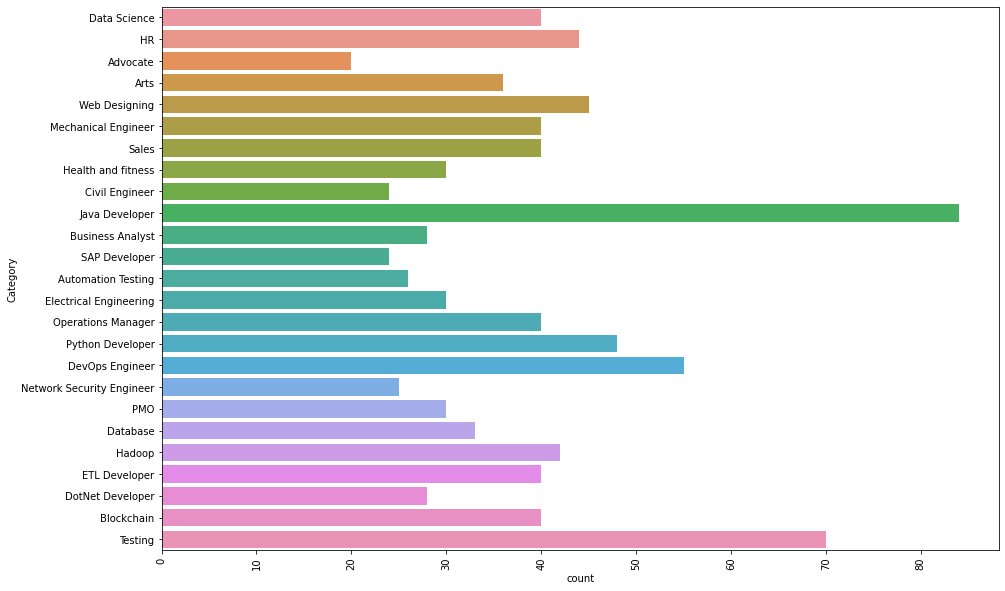

In [ ]:
import seaborn as sns
plt.figure(figsize=(15,10))
plt.xticks(rotation=90)
sns.countplot(y="Category", data=resumeDataSet)

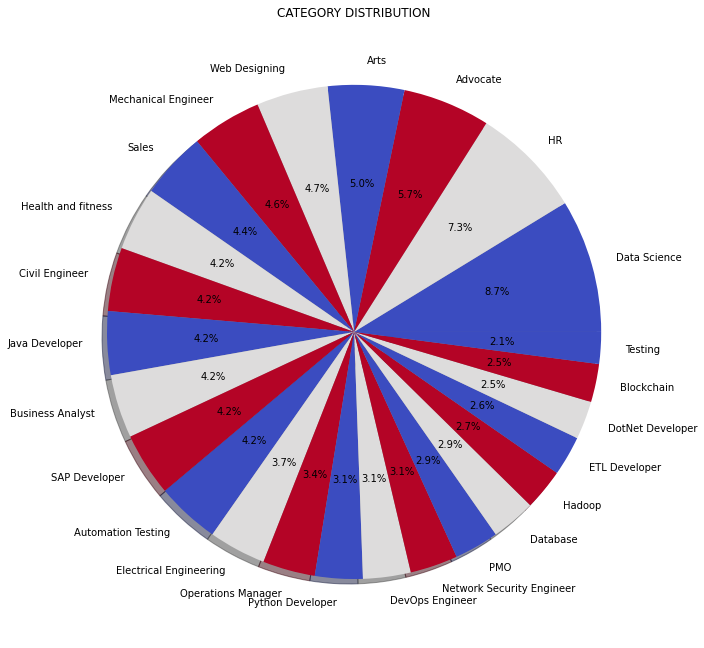

In [ ]:
from matplotlib.gridspec import GridSpec
targetCounts = resumeDataSet['Category'].value_counts()
targetLabels  = resumeDataSet['Category'].unique()
# Make square figures and axes
plt.figure(1, figsize=(25,25))
the_grid = GridSpec(2, 2)


cmap = plt.get_cmap('coolwarm')
colors = [cmap(i) for i in np.linspace(0, 1, 3)]
plt.subplot(the_grid[0, 1], aspect=1, title='CATEGORY DISTRIBUTION')

source_pie = plt.pie(targetCounts, labels=targetLabels, autopct='%1.1f%%', shadow=True, colors=colors)
plt.show()

In [ ]:
import re
def cleanResume(resumeText):
    resumeText = re.sub('http\S+\s*', ' ', resumeText)  # remove URLs
    resumeText = re.sub('RT|cc', ' ', resumeText)  # remove RT and cc
    resumeText = re.sub('#\S+', '', resumeText)  # remove hashtags
    resumeText = re.sub('@\S+', '  ', resumeText)  # remove mentions
    resumeText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', resumeText)  # remove punctuations
    resumeText = re.sub(r'[^\x00-\x7f]',r' ', resumeText) 
    resumeText = re.sub('\s+', ' ', resumeText)  # remove extra whitespace
    return resumeText
    
resumeDataSet['cleaned_resume'] = resumeDataSet.Resume.apply(lambda x: cleanResume(x))

In [ ]:
import nltk
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud

[('Details', 484), ('Exprience', 446), ('months', 376), ('company', 330), ('description', 310), ('1', 290), ('year', 232), ('January', 216), ('Less', 204), ('Data', 200), ('data', 192), ('Skill', 166), ('Maharashtra', 166), ('6', 164), ('Python', 156), ('Science', 154), ('I', 146), ('Education', 142), ('College', 140), ('The', 126), ('project', 126), ('like', 126), ('Project', 124), ('Learning', 116), ('India', 114), ('Machine', 112), ('University', 112), ('Web', 106), ('using', 104), ('monthsCompany', 102), ('B', 98), ('C', 98), ('SQL', 96), ('time', 92), ('learning', 90), ('Mumbai', 90), ('Pune', 90), ('Arts', 90), ('A', 84), ('application', 84), ('Engineering', 78), ('24', 76), ('various', 76), ('Software', 76), ('Responsibilities', 76), ('Nagpur', 76), ('development', 74), ('Management', 74), ('projects', 74), ('Technologies', 72)]


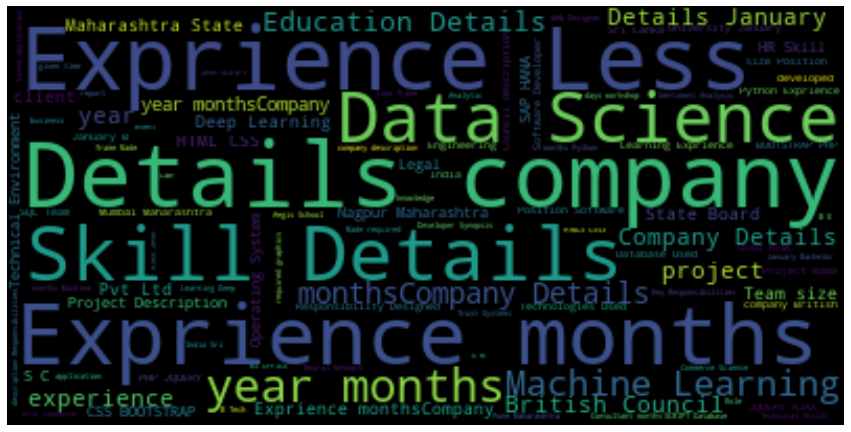

In [ ]:
oneSetOfStopWords = set(stopwords.words('english')+['``',"''"])
totalWords =[]
Sentences = resumeDataSet['Resume'].values
cleanedSentences = ""
for i in range(0,160):
    cleanedText = cleanResume(Sentences[i])
    cleanedSentences += cleanedText
    requiredWords = nltk.word_tokenize(cleanedText)
    for word in requiredWords:
        if word not in oneSetOfStopWords and word not in string.punctuation:
            totalWords.append(word)
    
wordfreqdist = nltk.FreqDist(totalWords)
mostcommon = wordfreqdist.most_common(50)
print(mostcommon)

wc = WordCloud().generate(cleanedSentences)
plt.figure(figsize=(15,15))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder

var_mod = ['Category']
le = LabelEncoder()
for i in var_mod:
    resumeDataSet[i] = le.fit_transform(resumeDataSet[i])

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

requiredText = resumeDataSet['cleaned_resume'].values
requiredTarget = resumeDataSet['Category'].values

word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    stop_words='english',
    max_features=1500)
word_vectorizer.fit(requiredText)
WordFeatures = word_vectorizer.transform(requiredText)

print ("Feature completed .....")

X_train,X_test,y_train,y_test = train_test_split(WordFeatures,requiredTarget,random_state=0, test_size=0.2)
print(X_train.shape)
print(X_test.shape)

Feature completed .....
(769, 1500)
(193, 1500)


In [ ]:
clf = OneVsRestClassifier(KNeighborsClassifier())
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
print('Accuracy of KNeighbors Classifier on training set: {:.2f}'.format(clf.score(X_train, y_train)))
print('Accuracy of KNeighbors Classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))

print("\n Classification report for classifier %s:\n%s\n" % (clf, metrics.classification_report(y_test, prediction)))

Accuracy of KNeighbors Classifier on training set: 0.99
Accuracy of KNeighbors Classifier on test set: 0.99

 Classification report for classifier OneVsRestClassifier(estimator=KNeighborsClassifier()):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      0.80      0.89         5
           3       1.00      1.00      1.00         9
           4       1.00      1.00      1.00         6
           5       0.83      1.00      0.91         5
           6       1.00      1.00      1.00         9
           7       1.00      1.00      1.00         7
           8       1.00      0.91      0.95        11
           9       1.00      1.00      1.00         9
          10       1.00      1.00      1.00         8
          11       0.90      1.00      0.95         9
          12       1.00      1.00      1.00         5
          13       1.00      1.00      1.

In [5]:
!pip install pdfminer.six


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from pandas.plotting import scatter_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from pdfminer.high_level import extract_text
import nltk
 

!pip install nltk

 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.6 MB 33.8 MB/s 
     |████████████████████████████████| 4.1 MB 54.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
import nltk
import glob

 
nltk.download('stopwords')
 
# you may read the database from a csv file or some other database
data=pd.read_csv("/content/drive/MyDrive/Ibtasam Ahmad DATA/skills.csv", encoding='cp1252')
SKILLS_DB=list(data.iloc[:,1])
 
 
def extract_text_from_pdf(pdf_path):
    return extract_text(pdf_path)
 
 
def extract_skills(input_text):
    stop_words = set(nltk.corpus.stopwords.words('english'))
    word_tokens = nltk.tokenize.word_tokenize(input_text)
    # remove the stop words
    filtered_tokens = [w for w in word_tokens if w not in stop_words]
    print(filtered_tokens)
 
    # remove the punctuation
    filtered_tokens = [w for w in word_tokens if w.isalpha()]
 
    # generate bigrams and trigrams (such as artificial intelligence)
    bigrams_trigrams = list(map(' '.join, nltk.everygrams(word_tokens, 2, 3)))
    print(bigrams_trigrams)
 
    # we create a set to keep the results in.
    found_skills = set()
    print(found_skills)
    # we search for each token in our skills database
    for token in bigrams_trigrams:
        if token.lower() in SKILLS_DB:
            found_skills.add(token)
 
    # we search for each bigram and trigram in our skills database
    for ngram in bigrams_trigrams:
        if ngram.lower() in SKILLS_DB:
            found_skills.add(ngram)
 
    return found_skills
 
 
if __name__ == '_main_':
  x=[]
  for i in glob.glob('/content/drive/MyDrive/Resume/*'):
    x.append(i)
  skill=[]
  for k in x:
      text = extract_text_from_pdf(k)
    # print(text)
      skills = extract_skills(text)
      a=input()
      j=0
      for i in skills:
        j=j+1
        if j==1:
          if a=="machine learning":
              print('job is relevent to this person')
          else:
            print('job is not for this person')
      skill.append(skills)
      print(skills) 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
if __name__ == '_main_':
  x=[]
  for i in glob.glob('/content/drive/MyDrive/Resume/*'):
    x.append(i)
  skill=[]
  for i in x:
      text = extract_text_from_pdf(i)
    # print(text)
      skills = extract_skills(text)
      a=input()
      j=0
      for i in skills:
        j=j+1
        if j==1:
          if a=="machine learning":
              print('job is relevent to this person')
          else:
            print('job is not for this person')
      skill.append(skills)
      print(skills) 

In [9]:
skill

NameError: ignored

In [2]:
  import glob
  x=[]
  for i in glob.glob('/content/drive/MyDrive/Resume/*'):
    x.append(i)

In [3]:
x

['/content/drive/MyDrive/Resume/Resume..pdf',
 '/content/drive/MyDrive/Resume/CV..pdf']

In [10]:
SKILLS_DB

['machine learning',
 'data science',
 'python',
 'word',
 'excel',
 'English',
 'deep learning',
 'electrical enigineer',
 'autocad',
 'html',
 'css',
 'mysql',
 'pakistan ',
 'proteus',
 'matlab',
 'simulink',
 'node-red',
 'leadership ',
 'team work ',
 'databaseÂ\xa0expert',
 'dataÂ\xa0analysis',
 'communicationÂ\xa0skills',
 'database',
 'microsoftÂ\xa0office',
 'administrativeÂ\xa0experience',
 'deepÂ\xa0learning',
 'customerÂ\xa0service',
 'microsoft office',
 'communication skills',
 'leadership ',
 'administrative ',
 'data analysis',
 'data scientist',
 'python',
 'c++',
 'Js ',
 'database',
 'deep learning',
 'Dusting',
 ' sweeping floors',
 ' washing floors',
 ' waxing',
 ' washing windows',
 'cleaning rugs or carpets',
 ' cleaning bathrooms',
 ' buffing',
 ' polishing furniture',
 ' plumbing repairs',
 ' electrical repairs',
 ' window repairs',
 ' carpentry work',
 ' publicrelations',
 ' money handling',
 ' supervisory experience',
 ' using computers',
 'Soldering',
 ' ass

In [11]:
import nltk
import glob
import nltk
import pandas as pd
 
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

 
nltk.download('stopwords')
 
# you may read the database from a csv file or some other database
data=pd.read_csv("/content/drive/MyDrive/Ibtasam Ahmad DATA/skills.csv", encoding='cp1252')
SKILLS_DB=list(data.iloc[:,1])
 
 
def extract_text_from_pdf(pdf_path):
    return extract_text(pdf_path)
 
 
def extract_skills(input_text):
    stop_words = set(nltk.corpus.stopwords.words('english'))
    word_tokens = nltk.tokenize.word_tokenize(input_text)
    # remove the stop words
    filtered_tokens = [w for w in word_tokens if w not in stop_words]
    print(filtered_tokens)
 
    # remove the punctuation
    filtered_tokens = [w for w in word_tokens if w.isalpha()]
 
    # generate bigrams and trigrams (such as artificial intelligence)
    bigrams_trigrams = list(map(' '.join, nltk.everygrams(word_tokens, 2, 3)))
    print(bigrams_trigrams)
 
    # we create a set to keep the results in.
    found_skills = set()
    print(found_skills)
    # we search for each token in our skills database
    for token in bigrams_trigrams:
        if token.lower() in SKILLS_DB:
            found_skills.add(token)
 
    # we search for each bigram and trigram in our skills database
    for ngram in bigrams_trigrams:
        if ngram.lower() in SKILLS_DB:
            found_skills.add(ngram)
 
    return found_skills
 
 
if __name__ == '__main__':
  x=[]
  for i in glob.glob('import nltk'):
    import glob


 
nltk.download('stopwords')
 
# you may read the database from a csv file or some other database
data=pd.read_csv("/content/drive/MyDrive/Ibtasam Ahmad DATA/skills.csv", encoding='cp1252')
SKILLS_DB=list(data.iloc[:,1])
 
 
def extract_text_from_pdf(pdf_path):
  return extract_text(pdf_path)
 
 
def extract_skills(input_text):
    stop_words = set(nltk.corpus.stopwords.words('english'))
    word_tokens = nltk.tokenize.word_tokenize(input_text)
    # remove the stop words
    filtered_tokens = [w for w in word_tokens if w not in stop_words]
    print(filtered_tokens)
 
    # remove the punctuation
    filtered_tokens = [w for w in word_tokens if w.isalpha()]
 
    # generate bigrams and trigrams (such as artificial intelligence)
    bigrams_trigrams = list(map(' '.join, nltk.everygrams(word_tokens, 2, 3)))
    print(bigrams_trigrams)
 
    # we create a set to keep the results in.
    found_skills = set()
    print(found_skills)
    # we search for each token in our skills database
    for token in bigrams_trigrams:
        if token.lower() in SKILLS_DB:
            found_skills.add(token)
 
    # we search for each bigram and trigram in our skills database
    for ngram in bigrams_trigrams:
        if ngram.lower() in SKILLS_DB:
            found_skills.add(ngram)
 
    return found_skills
 
 
if __name__ == '__main__':
  x=[]
  for i in glob.glob('/content/drive/MyDrive/Resume/*'):
    x.append(i)
  skill=[]
  for i in x:
      text = extract_text_from_pdf(i)
    # print(text)
      skills = extract_skills(text)
      a=input()
      j=0
      for i in skills:
        j=j+1
        if j==1:
          if a=="machine learning":
              print('job is relevent to this person')
          else:
            print('job is not for this person')
      skill.append(skills)
      print(skills) 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


NameError: ignored

In [ ]:
!pip install pdfminer.six

import nltk
import glob
import nltk
 
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

 
nltk.download('stopwords')
 
# you may read the database from a csv file or some other database
data=pd.read_csv("/content/drive/MyDrive/Ibtasam Ahmad DATA/skills.csv")
SKILLS_DB=list(data.iloc[:,1])
 
 
def extract_text_from_pdf(pdf_path):
    return extract_text(pdf_path)
 
 
def extract_skills(input_text):
    stop_words = set(nltk.corpus.stopwords.words('english'))
    word_tokens = nltk.tokenize.word_tokenize(input_text)
    # remove the stop words
    filtered_tokens = [w for w in word_tokens if w not in stop_words]
    print(filtered_tokens)
 
    # remove the punctuation
    filtered_tokens = [w for w in word_tokens if w.isalpha()]
 
    # generate bigrams and trigrams (such as artificial intelligence)
    bigrams_trigrams = list(map(' '.join, nltk.everygrams(word_tokens, 2, 3)))
    print(bigrams_trigrams)
 
    # we create a set to keep the results in.
    found_skills = set()
    print(found_skills)
    # we search for each token in our skills database
    for token in bigrams_trigrams:
        if token.lower() in SKILLS_DB:
            found_skills.add(token)
 
    # we search for each bigram and trigram in our skills database
    for ngram in bigrams_trigrams:
        if ngram.lower() in SKILLS_DB:
            found_skills.add(ngram)
 
    return found_skills
 
 
if __name__ == '__main__':
  x=[]
  for i in glob.glob('import nltk'):
    import glob


 
nltk.download('stopwords')
 
# you may read the database from a csv file or some other database
data=pd.read_csv('/content/drive/MyDrive/Ibtasam Ahmad DATA/skills.csv')
SKILLS_DB=list(data.iloc[:,1])
 
 
def extract_text_from_pdf(pdf_path):
    return extract_text(pdf_path)
 
 
def extract_skills(input_text):
    stop_words = set(nltk.corpus.stopwords.words('english'))
    word_tokens = nltk.tokenize.word_tokenize(input_text)
    # remove the stop words
    filtered_tokens = [w for w in word_tokens if w not in stop_words]
    print(filtered_tokens)
 
    # remove the punctuation
    filtered_tokens = [w for w in word_tokens if w.isalpha()]
 
    # generate bigrams and trigrams (such as artificial intelligence)
    bigrams_trigrams = list(map(' '.join, nltk.everygrams(word_tokens, 2, 3)))
    print(bigrams_trigrams)
 
    # we create a set to keep the results in.
    found_skills = set()
    print(found_skills)
    # we search for each token in our skills database
    for token in bigrams_trigrams:
        if token.lower() in SKILLS_DB:
            found_skills.add(token)
 
    # we search for each bigram and trigram in our skills database
    for ngram in bigrams_trigrams:
        if ngram.lower() in SKILLS_DB:
            found_skills.add(ngram)
 
    return found_skills
 
 
if __name__ == '__main__':
  x=[]
  for i in glob.glob('/content/drive/MyDrive/Resume/*'):
    x.append(i)
  skill=[]
  for i in x:
      text = extract_text_from_pdf(i)
    # print(text)
      skills = extract_skills(text)
      a=input()
      j=0
      for i in skills:
        j=j+1
        if j==1:
          if a== i:
              print('job is relevent to this person')
          else:
            print('job is not for this person')
      skill.append(skills)
      print(skills) 